# Conformal Prediction Beyond Exchangeability

In this notebook, we study the effect of non-exchangeability of the data on Conformal Prediction. We usually assume exchangeability of the data for the theoretical coverage guarantees to hold. However, when our calibration and test points are not sampled i.i.d., this assumption is often violated. This is generally the case in time series data or when we have a distribution drift and predict more recent points.

However, we will review the following paper to show that Conformal Prediction can still be applied in these settings and that we can control for the loss in prediction coverage:

*Barber, R. F., Candès, E. J., Ramdas, Tibshirani R. J. (2023). Conformal prediction beyond exchangeability. The Annals of Statistics. 51 (2) 816 - 845. Available from https://doi.org/10.1214/23-AOS2276*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from util import compute_coverage, regression_plot_with_uncertainty, regression_plot_with_scores

Let us assume we already trained a model $\hat{\mu}$ on some training data. We don't need to know this data for what follows. We could even use a complete black-box model that was handed over to us.

Our goal now is to use split conformal predictions with that model. So we define a calibration set
$$
(X_1, Y_1), \dots, (X_n, Y_n)
$$

We could then compute the residuals of the calibration set
$$
R_i = |Y_i - \hat{\mu}(X_i)|, i=1,\dots,n
$$

and obtain their $(1-\alpha)$-quantile $q$ to finally construct the following predictive interval for a test point $X_{n+1}$:

$$
\hat{C}_n (X_{n+1}) = \hat{\mu}(X_{n+1}) \pm q
$$

that covers the test label $Y_{n+1}$ with a target probability of $1-\alpha$. To be fully correct about theoretical guarantees, we take the $\lceil (1-\alpha)(n+1)\rceil$-th smallest score here.

This works if the elements $Z_1 := (X_1, Y_1), \dots, Z_{n+1} := (X_{n+1}, Y_{n+1})$ of our sequence are *exchangeable* meaning that their joint distribution remains the *same* after any permutation $\pi$ of its elements:

$$
P(Z_1,\dots,Z_{n+1}) = P(Z_{\pi(1)},\dots,Z_{\pi(n+1)})
$$

In fact, we can relax this requirement and only need to guarantee exchangeability for $R_1, \dots, R_{n+1}$, but more on that later.

For now we stick with $Z_1,\dots,Z_{n+1}$ and clarify this notion with a couple of examples:

In [2]:
# Number of calibration points (the n+1-th element is the test point)
n=9
# Number of random samples for each point in the sequence
num_samples=100

# Let's make the X_1, ..., X_{n+1} deterministic for now
X = np.arange(1, n+2)
# Define the random variables Y_i = 3*X_i + N(0,1) for i=1,...,n+1
# and let us draw 100 samples for every Y_i
Y = 3*X + np.random.normal(loc=0.0, scale=1.0, size=(num_samples, n+1))

Note that the $Y_i$s are statistically independent but not identically distributed in our example, since each $Y_i$ has a different mean:
$$
Y_i = 3 X_i + \epsilon_i \text{ with } \epsilon_i \sim \mathcal{N}(0,1) \iff Y_i \sim \mathcal{N}(3 X_i, 1)
$$

This fact makes them non-exchangeable. Let's understand this with a visualization.

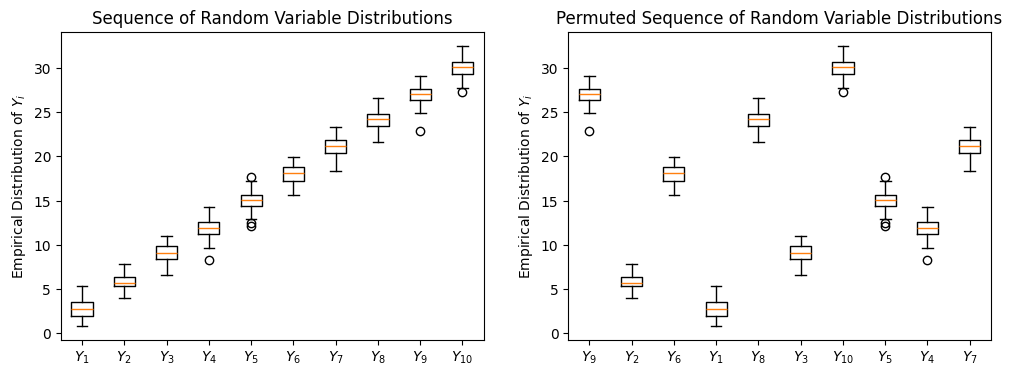

In [3]:
# Indices (1, ..., n+1)
indices = np.arange(0, len(X))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].boxplot([Y[:, i] for i in indices])
ax[0].set_xticks(indices+1, [f'$Y_{{ {val+1} }}$' for val in indices])
ax[0].set_ylabel('Empirical Distribution of $Y_i$')
ax[0].set_title('Sequence of Random Variable Distributions')

np.random.seed(42)
# Sample an arbitrary permutation π over (1, ..., n+1)
permutation = np.random.permutation(indices)

ax[1].boxplot(Y[:, indices[permutation]])
ax[1].set_xticks(indices+1, [f'$Y_{{ {val+1} }}$' for val in permutation])
ax[1].set_ylabel('Empirical Distribution of $Y_i$')
ax[1].set_title('Permuted Sequence of Random Variable Distributions')

plt.show()

Since the distribution $P(Y_1, Y_2, \dots)$ is different from the distribution $P(Y_9, Y_2, \dots)$, the random variables are *not* exchangeable. Note that this is already what we get in the *simplest* linear regression scenario where $Y_i = 3 X_i + \epsilon_i$.

Now you may ask: Why were we able to use Conformal Prediction for regression in the past notebooks? This is what we discuss next!

## How to ensure exchangeability via random data splits

In the past notebooks, we ensured exchangeability of the data by creating random train/test-splits. To be more precise, we randomly permuted a larger dataset $(X_1, Y_{1}), \dots, (X_{m}, Y_{m})$ with $m>n$ and divided its elements into a training/calibration/test split. The sampling procedure therefore looked as follows:

1) Obtain any general dataset of $m$ elements whith $m > n$ to make sure enough points remain for training and testing.
2) Shuffle the dataset randomly (achieved via a random permutation $\pi$)
3) Use any $n$ datapoints as a calibration set and divide the remaining ones between training and testing.

Steps 2. and 3. were achieved with `sklearn.model_selection.train_test_split` in our case.

Let's include the shuffling in our sampling procedure from before and verify that we actually obtain exchangeable data. Remember we had $n_{\rm trials}$ samples from the random variables $Y_1, \dots, Y_{n+1}$. So we need the same number of permutations now to simulate $n_{\rm trials}$ data splits. Let's try.

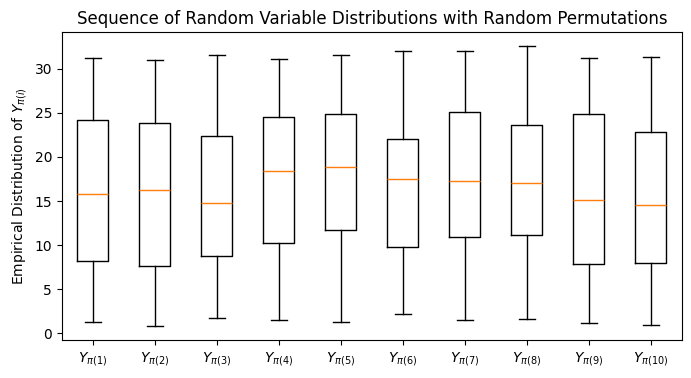

In [4]:
# We reshuffle the data from before for every sample
all_ys = np.zeros((num_samples, len(indices)))

for i in range(num_samples):
    current_perm = np.random.permutation(indices)
    current_y = Y[i, current_perm]
    all_ys[i] = current_y

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax.boxplot(all_ys)
ax.set_xticks(indices+1, [f'$Y_{{\pi( {val} )}}$' for val in indices+1])
ax.set_ylabel('Empirical Distribution of $Y_{\pi(i)}$')
ax.set_title('Sequence of Random Variable Distributions with Random Permutations')

plt.show()

Swapping e.g. $Y_{\pi(10)}$ with $Y_{\pi(4)}$ wouldn't affect the dstribution of the sequence anymore since all distributions are the same (up to some finite-sample imprecisions). So we can safely pick *any* $Y_{\pi(i)}$ as our test point and assign the remaining ones to the calibration set. This is exactly what we did in the previous notebooks.

## Conformal Prediction with Non-Exchangeable Data

What if our use case does not allow us to create random calibration/test-splits from the data? This problem actually arises very frequently in practice. One example are time series data, where the test set is chosen to lie in the future (opposed to being randomly drawn from the time range of previous data). Another one is distribution drift in sequential data. E.g., we may think about a recommender system, where we predict items of interest to a user in an online fashion. Since the user behavior and interest may change over time, the test data should rather be chosen from the present than from a random point in time.

Can we still use Conformal Prediction in this context? Of course we can! But coverage may suffer.

Let's assume our data is sampled as $Y_i = 3 X_i + \mathcal{N}(0, 1)$. This function is very simple to predict using linear regression and if the fit is good, the scores will stay accurate far into the future. If we include a changepoint at e.g. $X_i=2$ where the slope becomes zero and fit our model for $X_i < 2$, then the scores will increase for $X_i > 2$ because our fit becomes more and more inaccurate.

This is akin to fitting a model for predicting ice cream sales and training it over data from March to June. It will learn that sales increase over time as we approach summer. Then it will surely overpredict sales from Agust onwards since sales should already be at their maximum and not increase further.

Let's simulate this. We start by creating a function for standard Split Conformal Prediction (similar to the first notebook).

In [5]:
alpha = 0.05

def split_conformal_prediction(predictor, X_cal, y_cal, X_test, alpha=0.95):
    """ Standard Split Conformal Prediction """
    
    # Obtain scores and quantiles from the calibration set
    cal_mean_prediction = predictor.predict(X_cal)
    cal_scores = np.abs(y_cal - cal_mean_prediction)
    quantile = np.nanquantile(cal_scores, 1.0-alpha, method='higher')
    
    # Prediction intervals
    mean_prediction = predictor.predict(X_test)
    prediction_bands = np.stack([
        mean_prediction - quantile,
        mean_prediction + quantile
    ], axis=1)

    return mean_prediction, prediction_bands, quantile

Now we create two synthetic datasets and run Split Conformal Prediction on them. The first one has no changepoint while the second one does.

------------------------------
Dataset: No changepoint
------------------------------


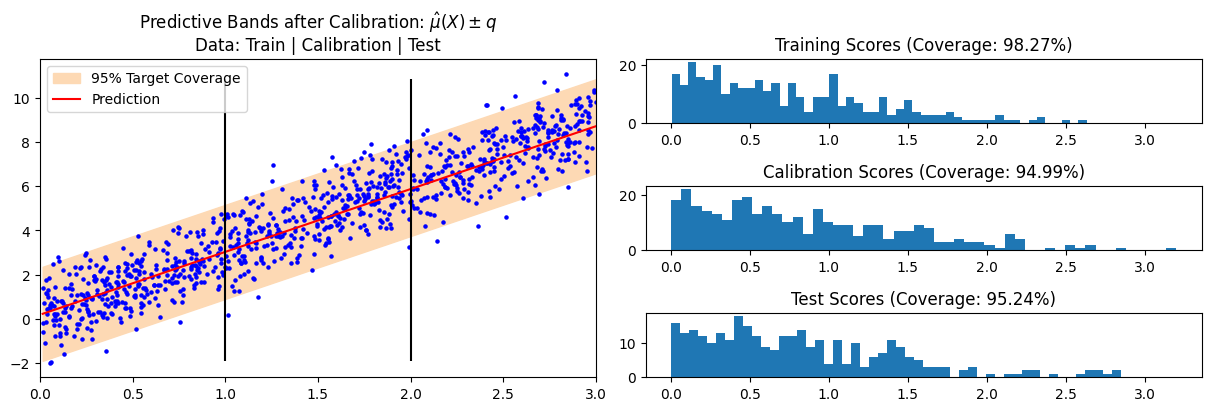

------------------------------
Dataset: Changepoint
------------------------------


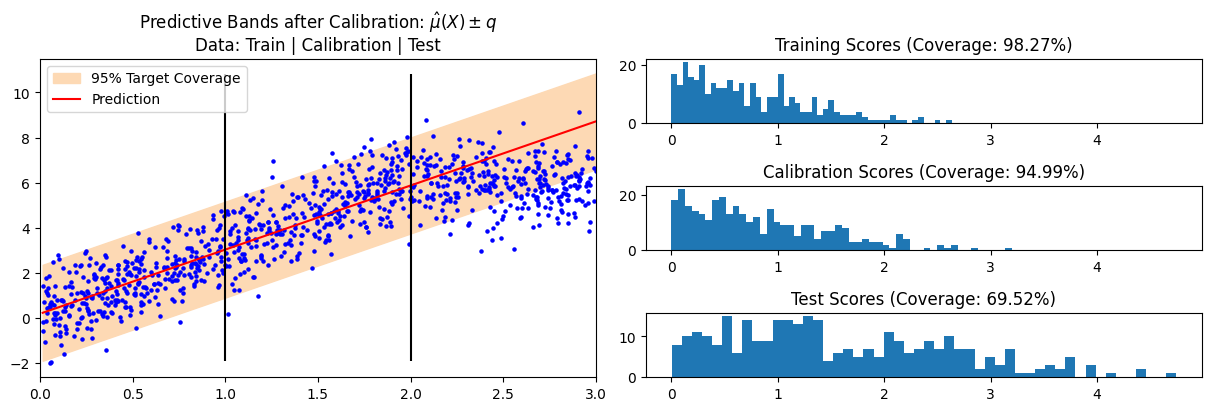

In [6]:
for dataset in ['No changepoint', 'Changepoint']:
    print('-'*30)
    print('Dataset: {}'.format(dataset))
    print('-'*30)
    
    # This is similar to the example of notebook 1, but this time we assign the largest x-values to the test data
    n_linear = 1000
    np.random.seed(42)
    X_linear = np.random.uniform(low=0.0, high=3.0, size=(n_linear, 1))
    y_linear = 3 * X_linear + np.random.normal(loc=0.0, scale=1.0, size=(n_linear, 1))

    if dataset == 'Changepoint':
        # we implement a changepoint at 2.0 at which the slope becomes zero
        above_threshold = X_linear.ravel() >= 2.0
        y_linear[above_threshold] = 0 * X_linear[above_threshold] + 6 + \
            np.random.normal(loc=0.0, scale=1.0, size=(len(X_linear[above_threshold]), 1))
    
    # Sequential data split: train=[0, 1], cal=(1, 2], test=(2, 3]
    idx_train, idx_cal, idx_test = X_linear.ravel() <= 1.0, (X_linear.ravel() > 1.0) & (X_linear.ravel() <= 2.0), X_linear.ravel() > 2.0
    X_train, X_cal, X_test = X_linear[idx_train], X_linear[idx_cal], X_linear[idx_test]
    y_train, y_cal, y_test = y_linear[idx_train], y_linear[idx_cal], y_linear[idx_test]
    
    # Fit linear regression on the training set
    mean_predictor = LinearRegression()
    mean_predictor.fit(X_train, y_train)
    
    # Standard split conformal prediction
    mean_prediction, prediction_bands, quantile = split_conformal_prediction(mean_predictor, X_cal, y_cal, X_linear, alpha)
    
    # |Y_i - \mu(X_i)| on train, calibration and test sets
    train_scores = np.abs(y_train - mean_predictor.predict(X_train))
    cal_scores = np.abs(y_cal - mean_predictor.predict(X_cal))
    test_scores = np.abs(y_test - mean_predictor.predict(X_test))
    
    # Create a regression plot (on the left) and a scores plot (on the right)
    regression_plot_with_scores(
        X_linear, mean_prediction, prediction_bands,
        (X_linear, y_linear), train_scores, cal_scores, test_scores,
        separators=[0, 1.0, 2.0, 3.0], quantile=quantile
    )

When there is no changepoint, we obtain close to 95% coverage on the test set despite not using exchangeable data (since we created the data splits on input intervals instead of randomly)! The reason this worked so well is that the *scores* are indeed exchangeable in this example. The noise distribution is constant across all x-values and our regression fit (red line) is very accurate. So the scores (absolute residuals) don't deteriorate over time.

This is very different when including a changepoint of the distribution at which we continue with zero slope. Then the coverage bands computed on the calibration set do not take this distribution shift into account. The score distribution of the test set looks quite different from the one of the calibration set and the scores are not exchangeable anymore.

## How much do the theoretical coverage guarantees suffer?

The [paper by Barber et al. (2023)](https://arxiv.org/abs/2202.13415) that we referred to in the beginning of this notebook derive the first theoretical coverage guarantees for non-exchangeable data.

They define the coverage gap as:

$$
{\rm Coverage\,gap} = (1 - \alpha) - \mathbb{P} \{ Y_{n+1} \in \hat{C}_n(X_{n+1}) \}
$$

where $(X_{n+1}, Y_{n+1})$ is our test point to be predicted, $1-\alpha$ the target coverage level, and $\hat{C}_n(X_{n+1})$ the prediction interval. The coverage gap basically indicates how much we deviate from the target coverage level with our prediction interval.

Then Barber et al. give an upper bound on this gap in terms of how much the exchangeability assumption on the scores is violated:

$$
{\rm Coverage\,gap} \leq \frac{\sum_{i=1}^n {\rm d_{TV}(R(Z), R(Z^i))}}{1 + n}
$$

Here $R(Z) := (R_1, \dots, R_{n+1})$ are the scores for our $n+1$ points (see the beginning of this notebook). $R(Z^i)$ is the same as $R(Z)$, but has the $i$-th element in the sequence swapped with $R_{n+1}$.
${\rm d_{TV}}$ is the [Total Variation Distance](https://en.wikipedia.org/wiki/Total_variation_distance_of_probability_measures) of two distributions which in our case can be expressed as:

$$
{\rm d_{TV}(R(Z), R(Z^i))} = \frac{1}{2} \int \Big| \mathbb{P}\{ R(Z) \} - \mathbb{P}\{ R(Z^i) \} \Big| \; dZ
$$

It measures how much the distributions $\mathbb{P}\{ R(Z) \}$ and $\mathbb{P}\{ R(Z^i) \}$ deviate. ${\rm d_{TV}(R(Z), R(Z^i))}$ is zero if the scores $R_1, \dots, R_{n+1}$ are exchangeable and larger than zero otherwise.

In the regression example without changepoint, our scores were indeed (almost) exchangeable and the coverage gap was therefore almost zero. So the theoretical bound above explains why we were able to use Conformal Prediction *despite* our points $(X_1, Y_1), \dots, (X_{n+1}, Y_{n+1})$ not being exchangeable! This is a great result because it tells us that we can apply Conformal Prediction to non-exchangeable data and choose our calibration points *arbitrarily* (e.g. pick the $n$ most recent samples), as long as the calibration scores are close to exchangeable with the test point score.

The less exchangeable our scores are, the higher the coverage gap becomes. In the example *with* changepoint, our test score distribution was very different from the calibration score distribution and the coverage of the preiction intervals deteriorated.

## Robustness against distribution drift

Lastly, the [paper by Barber et al. (2023)](https://arxiv.org/abs/2202.13415) proposes a method to *reduce* the coverage gap for non-exchangeable data. This is done by assigning weights $w_1, \dots, w_n \in [0, 1]$ to the calibration scores and computing a weighted $(1-\alpha)$-quantile.

This leads to the following refined upper bound on the coverage gap:

$$
{\rm Coverage\,gap} \leq \frac{\sum_{i=1}^n w_i \, {\rm d_{TV}(R(Z), R(Z^i))}}{1 + \sum_{i=1}^n w_i}
$$

which reduces to the original bound if we set $w_1 = \dots = w_n = 1$. So we can control the magnitude of this gap by picking larger weights $w_i$ for calibration scores that are more similar to the test scores and smaller weights for calibration scores that are different from the test score. E.g., when having a distribution shift, the most recent calibration points should probably receive larger weights than less recent ones.

Let's reproduce an experiment from Appendix F from the [paper](https://arxiv.org/abs/2202.13415) to see how this works in practice. We pick the distribution drift example (setting 3) and apply Split Conformal Prediction like in Figure 5. For this we need to generate the same distribution drift dataset. The ground-truth linear model is defined as $Y_i \sim X_i^\top \beta_i + \mathcal{N}(0, 1)$. $\beta_i$ itself is an interpolation between $(2, 1, 0, 0)^\top$ and $(0, 0, 2, 1)^\top$ to specify the distribution drift.

In [7]:
# Let's generate the data from appendix F (setting 3)

np.random.seed(12345)
N = 2000 # number of datapoints (one for each time step)
p = 4 # number of input dimensions
# number of random samples of this data
ntrial = 200 # reduce this number if the code takes to long to run!

X = np.random.normal(size=(ntrial,N,p))
Y = np.zeros((ntrial,N))
noise = np.random.normal(size=(ntrial,N))

# we define a linear model with its slope changing over time
# initial slope
beta_start = np.array([2,1,0,0])
# final slope
beta_end = np.array([0,0,2,1])
# interpolation of slopes
beta = beta_start + np.outer(np.arange(N)/(N-1), beta_end-beta_start)

for i in np.arange(N):
    # Linear model: x_i @ beta_i + \epsilon_i (beta drifts with each time step)
    Y[:,i] = X[:,i].dot(beta[i]) + noise[:,i]

Let's check how the ground-truth model parameter vector $\beta \in \mathbb{R}^4$ drifts over time.

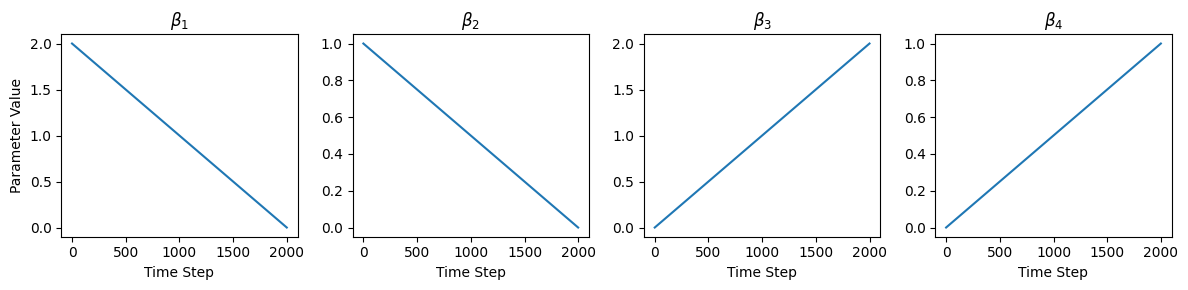

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
for beta_col in range(beta.shape[1]):
    ax[beta_col].plot(np.arange(N), beta[:, beta_col])
    ax[beta_col].set_title(r'$\beta_{}$'.format(beta_col+1))
    ax[beta_col].set_xlabel('Time Step')
    if beta_col == 0:
        ax[beta_col].set_ylabel('Parameter Value')
plt.tight_layout()
plt.show()

We can see that the 4 coefficients (one for every input dimension) are simply a linear interpolation over time. This describes how the input-output relationship drifts as we progress. We will now frame our prediction task as follows:

For every time step $n \in \{100, \dots, N-1\}$, we try to predict $Y_{n+1}$ using the $n$ previous points for training and calibration. The training points are simply the odd indices and the calibration points the even ones up to $n$. We therefore have a 50/50 training/calibration split that is *not random*, but arbitrarily chosen. The calibration scores are therefore most likely *not exchangeable* with the test score at $n+1$.

However, we would expect more recent calibration scores (closer to $n$) to be more similar to the test point score, which is why we give them a larger weight in the weighted Conformal Prediction approach. More precisely, we set $w_i = 0.99^{n+1-i}$ for $i=1,\dots,n$ and by default we assign $w_{n+1}=1$. E.g., for $n=100$ this gives:

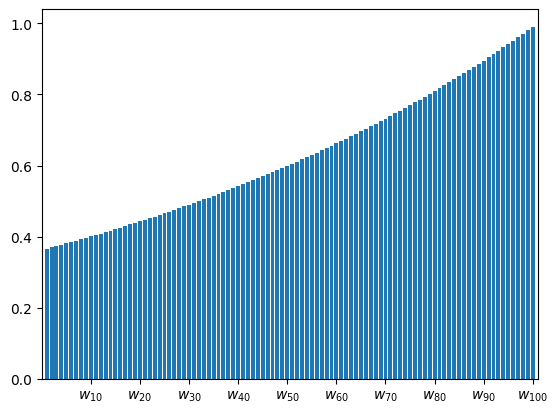

In [9]:
# We are at n=100. So n+1-i = 100, 99, ... for i=1, 2, ...
w = 0.99**np.arange(100,0,-1)
plt.bar(np.arange(1, len(w)+1), w)
plt.xlim(0, 101)
plt.xticks(
    [10*i for i in range(1,11)],
    [f'$w_{{{10*i}}}$' for i in range(1,11)]
)
plt.show()

We see that we assign increasing weights to more recent datapoints.

Next, we define the weighted Split Conformal Prediction procedure. For the non-weighted approach, we would take the $\lceil(1-\alpha)(n+1)\rceil$-smallest value of the $n$ calibration scores. This could equivalently be expressed as (Equation 5 in the [paper](https://arxiv.org/abs/2202.13415)):

$$
{\rm Q_{1-\alpha}} \Big( \underbrace{\sum_{i=1}^n \frac{1}{n+1} \delta_{R_i} + \frac{1}{n+1} \delta_{+\infty}}_{\rm Empirical\,Score\,Distribution} \Big)
$$

This means we take the $(1-\alpha)$-quantile of a uniform distribution that has a probability of $\frac{1}{n+1}$ at every $R_1, \dots, R_{n}$ and at $+\infty$ (the $\delta$ terms are point masses [see Slide 7 here](https://www.its.caltech.edu/~zuev/teaching/2013Spring/Math408-Lecture-3.pdf)).

For weighted quantiles this becomes (Equation 11 in the [paper](https://arxiv.org/abs/2202.13415)):

$$
{\rm Q_{1-\alpha}} \Big( \underbrace{\sum_{i=1}^n \tilde{w}_i \delta_{R_i} + \tilde{w}_{n+1} \delta_{+\infty}}_{\rm Weighted\,Empirical\,Score\,Distribution} \Big)
$$

where the weights are now normalized: $\tilde{w}_i := \frac{w_i}{w_1 + \dots + w_{n} + 1}$. $w_{n+1}$ always equals $1$. In practice, this means we need to sum up our normalized weights $\tilde{w}_i$ in ascending order of the scores $R_i$ and pick the score where this sum is at least $1-\alpha$. This may seem a bit confusing, but is actually quite simple as shown in the following code.

In [10]:
def weighted_split_conformal_prediction(predictor, X_cal, y_cal, X_test, cal_weights, alpha=0.95):
    """ Weighted Split Conformal Prediction (taken from github.io/code/nonexchangeable_conformal.zip) """

    # normalize weights (we add +1 in the denominator for the test point at n+1)
    weights_normalized = cal_weights / (np.sum(cal_weights)+1)

    if(np.sum(weights_normalized) >= 1-alpha):
        # calibration scores: |y_i - x_i @ betahat|
        R = np.abs(y_cal - predictor.predict(X_cal))
        ord_R = np.argsort(R)
        # from when are the cumulative quantiles at least 1-\alpha
        ind_thresh = np.min(np.where(np.cumsum(weights_normalized[ord_R])>=1-alpha))
        # get the corresponding residual
        quantile = np.sort(R)[ind_thresh]
    else:
        quantile = np.inf
    
    # Standard prediction intervals using the absolute residual score quantile
    mean_prediction = predictor.predict(X_test)
    prediction_bands = np.stack([
        mean_prediction - quantile,
        mean_prediction + quantile
    ], axis=1)

    return mean_prediction, prediction_bands, quantile

Now we run `n_trials` prediction tasks. For each task, we predict the test point $n+1$ at `N-train_lag` time steps. Since the model is retrained for every $n$, this gives a total of `n_trials*(N-train_lag)` regression problems to accurately reproduce the experiments of the paper. This takes around 7 minutes on my machine. So feel free to reduce `n_trials` to something like 10 instead of 200 if this takes too long.

In [11]:
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

# start predicting after train_lag many observations
train_lag = 100
# parameters for weight and tag decay
rho = 0.99; rho_LS = 0.99
# target miscoverage level
alpha = 0.1

# conformal prediction methods: standard split CP, weighted split CP, weighted split CP with weighted LR
methods = ['CP-LS','nexCP+LS','nexCP+WLS']
# prediction interval placeholder
PI_split_CP = np.zeros((len(methods),ntrial,N,2))
# set the prediction interval to [-inf, +inf] for points that we don't predict
PI_split_CP[:,:train_lag,0]=-np.inf; PI_split_CP[:,:train_lag,1]=np.inf

for itrial in tqdm(np.arange(ntrial)):
    # we repeat the experiment ntrial times
        
    for pred_idx in np.arange(train_lag, N):
        # we predict the point at pred_idx (n+1) starting at pred_idx=train_lag (101-th datapoint)

        for method_idx, method in enumerate(methods):
            # calibration weights for non-exchangeable conformal prediction (nexCP)
            if method in ['nexCP+LS', 'nexCP+WLS']:
                # weights at 1, ..., n (notice: in Python arrays this becomes 0, ..., n-1)
                weights = rho**(np.arange(pred_idx,0,-1))
                # weight n+1 should always be 1
                weights = np.r_[weights,1]
            else:
                weights = np.ones(pred_idx+1)
            
            # weights for weighted linear regression (WLS)
            if method == 'nexCP+WLS':
                # tags 1, ..., n+1
                tags = rho_LS**(np.arange(pred_idx,-1,-1))
            else:
                tags = np.ones(pred_idx+1)

            # odd data points for training, even ones for calibration
            inds_odd = np.arange(1,int(np.ceil(pred_idx/2)*2-1),2) # excludes pred_idx
            inds_even = np.arange(2,int(np.floor(pred_idx/2)*2),2) # excludes pred_idx

            # train a weighted least squares regression (tags are the weights)
            predictor = LinearRegression()
            predictor.fit(X[itrial, inds_odd], Y[itrial, inds_odd], tags[inds_odd])

            mean_prediction, prediction_bands, quantile = weighted_split_conformal_prediction(
                predictor, # the trained weighted linear regression model
                X[itrial, inds_even], # calibration inputs
                Y[itrial, inds_even], # calibration targets
                X[itrial, pred_idx][np.newaxis, :], # test point to predict
                weights[inds_even], # calibration score weights
                alpha # target miscoverage rate
            )
            PI_split_CP[method_idx,itrial,pred_idx,:] = prediction_bands

100%|█████████████████████████████████████████| 200/200 [07:11<00:00,  2.16s/it]


Here we compute the coverage scores and prediction interval widths for every time step $n+1$ averaged over `n_trials`.

In [12]:
coverage = np.zeros((len(method), N-train_lag))
pi_width = np.zeros((len(method), N-train_lag))

# compute coverage for each time step and trial
for method_idx, method in enumerate(methods):
    lower_bound = PI_split_CP[method_idx, :, train_lag:, 0]
    upper_bound = PI_split_CP[method_idx, :, train_lag:, 1]

    # coverage is averaged over ntrials
    coverage[method_idx] = np.mean((lower_bound <= Y[:,train_lag:]) & (upper_bound >= Y[:,train_lag:]), axis=0)
    pi_width[method_idx] = np.mean(upper_bound - lower_bound, axis=0)

Finally, let's reproduce Figure 5 from the [paper](https://arxiv.org/abs/2202.13415).

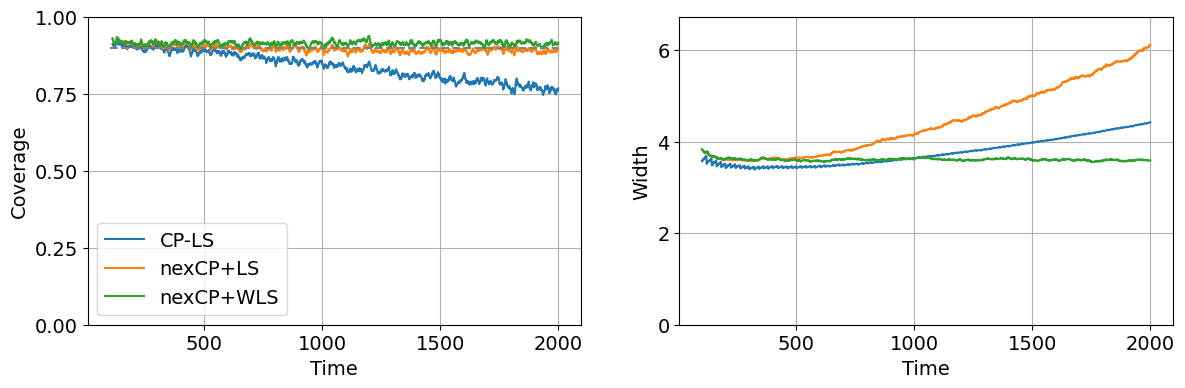

In [13]:
plt.rcParams.update({'font.size': 14})

window = 10 # will display a rolling average

def rolling_avg(x,window):
    return np.convolve(x, np.ones(window)/window)[(window-1):-window]
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))

for method_idx, method in enumerate(methods):
    ax[0].plot(np.arange(train_lag+window,N), rolling_avg(coverage[method_idx], window))
    ax[1].plot(np.arange(train_lag, N), pi_width[method_idx])

ax[0].hlines(1-alpha, xmin=train_lag, xmax=N, linestyles='--', colors='gray')
ax[0].legend(['CP-LS','nexCP+LS','nexCP+WLS'])

ax[0].set_ylabel('Coverage')
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax[0].set_xlabel('Time')
ax[0].grid(True)

ax[1].set_ylabel('Width')
ymax = np.max([
    pi_width[method_idx].max() for method_idx in range(len(methods))
]) * 1.1
ax[1].set_ylim([0, ymax])
ax[1].set_yticks([0, 2, 4, 6])
ax[1].set_xlabel('Time')
ax[1].grid(True)

plt.show()

We see that the weighted Conformal Prediction methods are more robust to the distribution drift. Classical CP (CP-LS) looses coverage because of adapting the prediction bands too slowly. Non-exchangeable (weighted) Conformal Prediction (nexCP) has more strongly growing prediction bands to maintain the target coverage under misprediction. nexCP with weighted linear regression does not need to grow the bands as the model is more accurate.

Finally, we verify that the coverage scores and prediction interval widths match the ones from Table 4.

In [14]:
for method_idx, method in enumerate(methods):
    print(f'{method}')
    print('-'*10)
    print(f'Avg. coverage: {np.mean(coverage[method_idx]):.3f}')
    print(f'Avg. interval width: {np.mean(pi_width[method_idx]):.2f}')
    print()

CP-LS
----------
Avg. coverage: 0.839
Avg. interval width: 3.76

nexCP+LS
----------
Avg. coverage: 0.896
Avg. interval width: 4.44

nexCP+WLS
----------
Avg. coverage: 0.914
Avg. interval width: 3.61



Our scores and widths are very close to the ones from the original paper (setting 3):

<img src='../../img/SCP_data_drift_scores.png' width=600 />

And that's it! We have learned that we can apply Conformal Prediction to non-exchangeable data and control for the coverage loss by smartly choosing the calibration set and assigning weights to it. There exist other methods to account for non-exchangeable data including [Adaptive Conformal Inference](https://proceedings.neurips.cc/paper/2021/hash/0d441de75945e5acbc865406fc9a2559-Abstract.html). The difference is that these methods use online quantile updates taking recent prediction errors into account. We will discuss them in another notebook.